In [1]:
import pickle

import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


SEED = 123

# Let's get the dataset

We are retrieving the dataset from the file created by the `Data Processing.ipynb` notebook.

In [2]:
df = pd.read_csv('dataset_rw.csv')
df.head()

,Unnamed: 0,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,...,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0
1,1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
2,2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
3,3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q3,0
4,4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0


Let's define some training columns for the baseline model. We will start with the expanding window features representing the number of communications for inbound, outbound, indirect emails as well as meetings.

In [3]:
train_columns = ['n__fc__x', 'n__tc__x', 'n__fo__x', 'n__me__x']
train_columns

['n__fc__x', 'n__tc__x', 'n__fo__x', 'n__me__x']

The code below shows the distribution of the positive classes across different levels of data aggregation. 18.9% of opportuntiies are won at some point. Less so, only 8% of opportunity-quarters are positive. This means that opportunities, on average, even if won eventually, are won after several quarters of being open (being a negative class). 

Finally, only 5% of the opportunity-days represent positive classes. This means that there will be a high class imbalance that we will need to account for.

In [4]:
# this column shows the % of the opportunities closed successfully
p_opp_won = df.groupby(['OpportunityId'], as_index=False).agg({'target': 'max'}).target.astype(int).mean()
p_opp_fq_won = df.groupby(['OpportunityId', 'CreatedDate__fq'], as_index=False).agg({'target': 'first'}).target.astype(int).mean()
# and the number of rows that have target == 1
p_samples_won = df.target.mean()

print(f"% of Opportunities Won: {p_opp_won*100:.2f}%")
print(f"% of Opportunity-FQs Won: {p_opp_fq_won*100:.2f}%")
print(f"% of Opportunity-Days Won: {p_samples_won*100:.2f}%")

% of Opportunities Won: 18.87%
% of Opportunity-FQs Won: 8.08%
% of Opportunity-Days Won: 5.01%


The below cell groups all opportunity-days by fiscal quarter and opportunity identifier (target for each group is the same). This is used to split the data into training and test sets - we should avoid putting data points from the same opportunity-quarter into two datasets as it might trick the model.

Additionally, after obtaining training the test sets, we further cut the training set to speed up the baseline model training process. The test set is further split into test and validation sets.

The final distribution of data is as follows:
- training set: 30% of all opportunity-quarters
- test set: 20% of all opportunity-quarters
- validation set: 20% of all opportunity-quarters

The rest 30% is temporarily discarded but will be used in the training set in the future. All opportunity-quarters are split in a stratified way with the outcome variable in mind to ensure that the class imbalance problem doesn't propagate further.

In [5]:
# this identifies unique sets of Opportunities and FQs, because the target is the same for each pair (Opp, FQ)
unique_params = df[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, test_size=0.4, stratify=unique_params['target'], random_state=SEED)

# next, we take only samples of this whole dataset to speed up model training/testing
# taking 0.6 * 0.5 = 0.3 for train 
train_params, _ = train_test_split(train_params, test_size=0.8, stratify=train_params['target'], random_state=SEED)
# taking 0.4*0.5 = 0.2 for test and 0.540.5=0.2 for validation for lgbm
test_params, val_params = train_test_split(test_params, test_size=0.5, stratify=test_params['target'], random_state=SEED)

The following cell assigns opportunity-days to train, test, or validation sets based on their identifiers and quarters.

In [6]:
train = []
test = []
val = []

df_shuffled = df.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
val_params = set(list(val_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))


for name, group in grouped:
    if name in train_params:
        train.append(group)
    elif name in test_params:
        test.append(group)
    elif name in val_params:
        val.append(group)

train = pd.concat(train)
test = pd.concat(test)
val = pd.concat(val)


In [7]:
#print(train[train_columns].shape, test[train_columns].shape, val[train_columns].shape)
print(f"Opportunity-days won in df: {df.target.mean():.4f}")
print(f"Opportunity-days won in train: {train.target.mean():.4f}")
print(f"Opportunity-days won in test: {test.target.mean():.4f}")
print(f"Opportunity-days won in test: {val.target.mean():.4f}")

Opportunity-days won in df: 0.0501
Opportunity-days won in train: 0.0517
Opportunity-days won in test: 0.0499
Opportunity-days won in test: 0.0538


From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

Since we are using SVCs, it's a good practice to normalize the data. For that, we will take the log of data to reduce its skewness attributable to the high sparsity. Then, we rescale the data to a smaller range of values to optimize for the SVC's speed. We train the scaler on train data but then apply it to the testing and validation sets as well. Final data distributions for train set are provided below

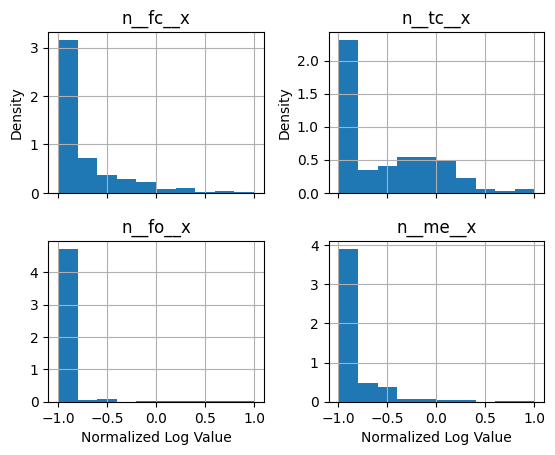

In [8]:
# df2 will contain log of the feature because the distributions are very skewed

scaler = None
for dataset in [train, test, val]:
    for feature in train_columns:
        dataset[feature] = np.log1p(dataset[feature])

    # this condition will be entered only for the train set
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1,1)) 
        scaler.fit(dataset[train_columns])
        dataset[train_columns] = scaler.transform(dataset[train_columns])
        
        fig, ax = plt.subplots(2, 2, sharex=True)
        train[train_columns].hist(density=True, ax=ax)
        ax[1][0].set_xlabel('Normalized Log Value')
        ax[1][1].set_xlabel('Normalized Log Value')
        ax[0][0].set_ylabel('Density')
        ax[0][1].set_ylabel('Density')
        plt.show()
    else:
        dataset[train_columns] = scaler.transform(dataset[train_columns])
    



Now, let's add some synthetical samples to the train data to decrease the imbalance. We use SMOTE for this.

In [9]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [10]:
print(train[train_columns].shape, test[train_columns].shape)
print(f"Opportunity-days won in train: {train.target.mean():.3f}")
print(f"Opportunity-days won in test: {test.target.mean():.3f}")

(20246, 4) (31757, 4)
Opportunity-days won in train: 0.100
Opportunity-days won in test: 0.050


## Candidate 1: SVC - Support Vector Classifier

In [11]:
# proceed with "standard" parameters
svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED, probability=True, tol=0.1, verbose=1)
svc.fit(train[train_columns], train.target)

[LibSVM].............
*.
*.
*.
*
optimization finished, #iter = 14756
obj = -13037.604293, rho = -2.000721
nSV = 13052, nBSV = 11796
Total nSV = 13052
.............
*.
*.
*
optimization finished, #iter = 15202
obj = -13249.633599, rho = -1.867430
nSV = 13267, nBSV = 12405
Total nSV = 13267
..............
**.
*
optimization finished, #iter = 15337
obj = -13363.992504, rho = -1.898296
nSV = 13380, nBSV = 12213
Total nSV = 13380
.............
*.
*.
*
optimization finished, #iter = 14660
obj = -12914.943502, rho = -1.875356
nSV = 12928, nBSV = 11657
Total nSV = 12928
.............
*.
*.
*
optimization finished, #iter = 15175
obj = -13065.951935, rho = -1.801925
nSV = 13082, nBSV = 11808
Total nSV = 13082
................
*.
*
optimization finished, #iter = 17450
obj = -16415.941643, rho = 1.907715
nSV = 16430, nBSV = 14672
Total nSV = 16430


SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=123, tol=0.1, verbose=1)

In [12]:
# get predictions 
test['svc_pred'] = svc.predict(test[train_columns])
test['svc_proba'] = svc.predict_proba(test[train_columns])[:, 1]
train['svc_pred'] = svc.predict(train[train_columns])
train['svc_proba'] = svc.predict_proba(train[train_columns])[:, 1]

Let's save the model in case we decide to reference it later

In [13]:
with open('svc_model.pkl', 'wb') as f:
    pickle.dump(svc, f)

test.to_csv('test.csv')
train.to_csv('train.csv')

## Candidate 2: LightGBM - Random Forest

For the LightGBM, there is a small template that uses optuna to optimize some hyperparameters. Let's train it in 40 iterations, optimizing over a subset of hyperparameters. A more thorough analysis is yet to come.

Here, we will use the validation set to guide the training process and reduce overfit. The training metric will be log-loss to account for the probabilities and not discrete values

In [14]:
trial_config = {
  'suggest_float':
    {
        # 'reg_alpha': {'name': 'reg_alpha', 'low': 1e-3, 'high': 10.0, 'log': True},
        # 'reg_lambda': {'name': 'reg_lambda', 'low': 1e-3, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.001, 'high': 0.1, 'log': True},
        # 'subsample': {'name': 'subsample', 'low': 0.2, 'high': 1},
        # 'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },

  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        # 'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        # 'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 2700},
    }
    
}

In [22]:
def objective_timecv_everyday(data: pd.DataFrame, trial: optuna.Trial) -> float:
    """
    DEPRECATED
    
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    def custom_time_split(x, y):
        groups = x.groupby('CreatedDate__fq')
        train_idx, test_idx = [], []
        for _, group in groups:
            test_idx = group.index
            if train_idx:
                yield train_idx, test_idx
            train_idx.extend(group.index)

    data = data.sort_values(by=['CreatedDate'], ascending=True)
    X, y = data, data.target  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    for train_idx, test_idx in tqdm(custom_time_split(X, y)):
        splits += 1
        # split the dataset into test and train using the custom function above
        x_train, y_train = X.loc[train_idx], y.loc[train_idx]
        x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # use the previously fitted model if possible
        boost = model if model.__sklearn_is_fitted__() else None
        
        model.fit(x_train[train_columns], y_train, init_model=boost)
        
        # generate predictions for the unseen quarter and save it
        y_pred = model.predict_proba(x_test[train_columns])[:, 1]
        metric = log_loss(y_test, y_pred, labels=[0, 1])
        avg_metric.append(metric)

    weights = (np.arange(splits) + 1) / np.sum(np.arange(splits))
    
    return np.dot(avg_metric, weights)


def objective_for_stratified(train_data: pd.DataFrame, val_data, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    train_data: pd.DataFrame - the train dataset
    val_data: pd.DataFrame - the validation dataset 
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = train_data[train_columns], val_data[train_columns], train_data.target, val_data.target
        
    model.fit(x_train[train_columns], y_train)
        
    # generate predictions for the unseen quarter and save it
    y_proba = model.predict_proba(x_test[train_columns])[:, 1]
    y_pred = model.predict(x_test[train_columns])
    metric = log_loss(y_test, y_proba, labels=[0, 1])
    #metric = matthews_corrcoef(y_test, y_pred)
    #print(metric)
    return metric


def get_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model


def optimize(train_data, val_data, objective, n_trials):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    LightGBMClassifier - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(train_data, val_data, trial), n_trials=n_trials)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(train_data[train_columns], train_data.target)
    return model

In [23]:
lgbm = optimize(train, val, objective_for_stratified, 40)

[I 2023-10-27 18:12:16,851] A new study created in memory with name: no-name-bc9c6ea2-ba3b-4012-b5a7-bb4f961e9054
[I 2023-10-27 18:12:17,931] Trial 0 finished with value: 0.6001470232059879 and parameters: {'learning_rate': 0.02471373418487883, 'min_split_gain': 0.20743614111576184, 'min_child_weight': 0.0006563455496532599, 'n_estimators': 556, 'num_leaves': 1475}. Best is trial 0 with value: 0.6001470232059879.
[I 2023-10-27 18:12:21,617] Trial 1 finished with value: 0.5883753261061869 and parameters: {'learning_rate': 0.007017992831138443, 'min_split_gain': 0.6867272968853846, 'min_child_weight': 0.029295290046841112, 'n_estimators': 486, 'num_leaves': 807}. Best is trial 1 with value: 0.5883753261061869.
[I 2023-10-27 18:12:22,503] Trial 2 finished with value: 0.6316922211659399 and parameters: {'learning_rate': 0.004856865002051283, 'min_split_gain': 0.5130442980949886, 'min_child_weight': 0.003799824476039986, 'n_estimators': 69, 'num_leaves': 819}. Best is trial 1 with value: 0.

In [24]:
test['lgbm_pred'] = lgbm.predict(test[train_columns])
test['lgbm_proba'] = lgbm.predict_proba(test[train_columns])[:, 1]
train['lgbm_pred'] = lgbm.predict(train[train_columns])
train['lgbm_proba'] = lgbm.predict_proba(train[train_columns])[:, 1]

## Let's compare 'em

The code cell below outputs metrics on the predictions for test and train classes as well as produces confusion matrices and precision-recall AUC curves.

SVC  F1=0.1311 Precision=0.0821 Recall=0.3243 MattScore=0.0733 
LGBM F1=0.1259 Precision=0.1036 Recall=0.1603 MattScore=0.0713 

[Train] SVC F1=0.2923 Precision=0.2048 Recall=0.5104 MattScore=0.2014 
[Train] LGBM F1=0.6127 Precision=0.6385 Recall=0.5889 MattScore=0.5722 


<Figure size 640x480 with 0 Axes>

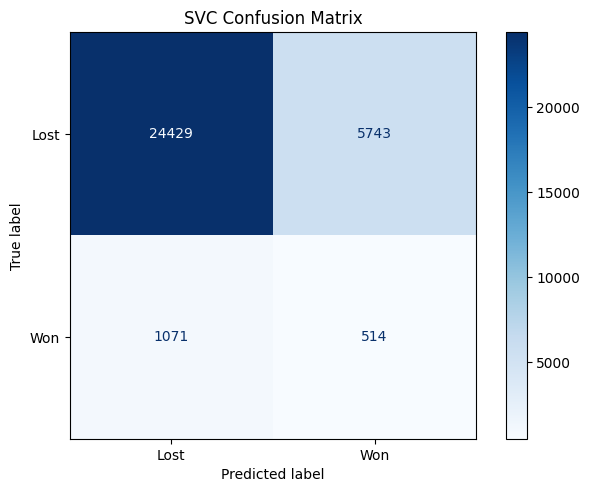

<Figure size 640x480 with 0 Axes>

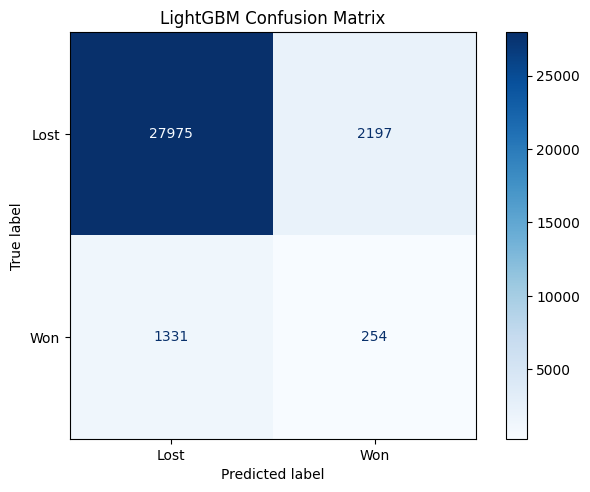

<Figure size 640x480 with 0 Axes>

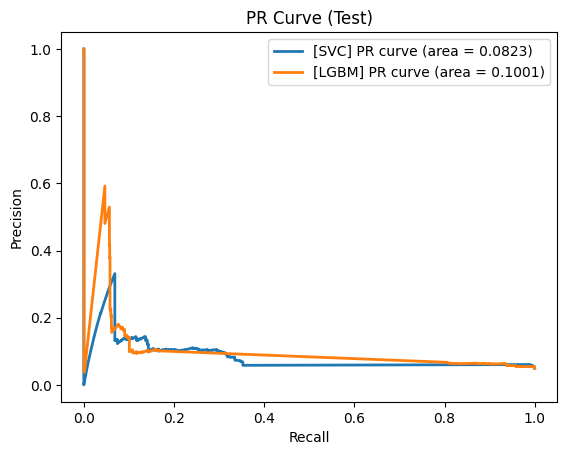

<Figure size 640x480 with 0 Axes>

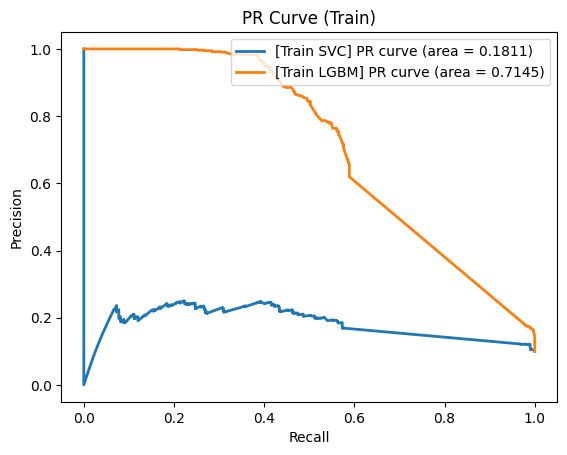

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = precision_recall_curve(y_true, pred)
            pr_auc = auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)
print(
    f"SVC  "
    f"F1={f1_score(test.target, test.svc_pred):.4f} "
    f"Precision={precision_score(test.target, test.svc_pred):.4f} "
    f"Recall={recall_score(test.target, test.svc_pred):.4f} "
    f"MattScore={matthews_corrcoef(test.target, test.svc_pred):.4f} "
)
print(
    f"LGBM "
    f"F1={f1_score(test.target, test.lgbm_pred):.4f} "
    f"Precision={precision_score(test.target, test.lgbm_pred):.4f} " 
    f"Recall={recall_score(test.target, test.lgbm_pred):.4f} "
    f"MattScore={matthews_corrcoef(test.target, test.lgbm_pred):.4f} "
)
print()
print(
    f"[Train] SVC "
    f"F1={f1_score(train.target, train.svc_pred):.4f} "
    f"Precision={precision_score(train.target, train.svc_pred):.4f} " 
    f"Recall={recall_score(train.target, train.svc_pred):.4f} "
    f"MattScore={matthews_corrcoef(train.target, train.svc_pred):.4f} "
)
print(
    f"[Train] LGBM "
    f"F1={f1_score(train.target, train.lgbm_pred):.4f} "
    f"Precision={precision_score(train.target, train.lgbm_pred):.4f} " 
    f"Recall={recall_score(train.target, train.lgbm_pred):.4f} "
    f"MattScore={matthews_corrcoef(train.target, train.lgbm_pred):.4f} "
)
plot_confusion_matrix(test.target.astype(int), test.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(test.target.astype(int), test.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(test.target.astype(int), [test.svc_proba, test.lgbm_proba], labels=['SVC', 'LGBM'], title='PR Curve (Test)')
plot_pr_auc(train.target.astype(int), [train.svc_proba, train.lgbm_proba], labels=['Train SVC', 'Train LGBM'], title='PR Curve (Train)')


Based on the figures above, the following conclusions can be made about the baseline models. First, there is a clear overfit for both models, as they perform relatively well on the train sets but much less so on the test sets. While this is expected for SVCs that weren't tested against validation sets during training, this is unexpected for the LightGBM (with PR AUC being 0.1 for test but 0.71 for train), whose metric evaluation was conducted on the validation set during testing.

Nevertheless, SVC seems to perform marginally better - recall, which is an important metric in this scenario as we want to minimize false negatives, is significantly higher. SVC is generally better at figuring positive cases while not significantly losing in precision to LightGBM. It is likely that over larger sets of hyperparameters, LightGBM will be able to reduce its overfit and perform better on unseen data.

<Figure size 640x480 with 0 Axes>

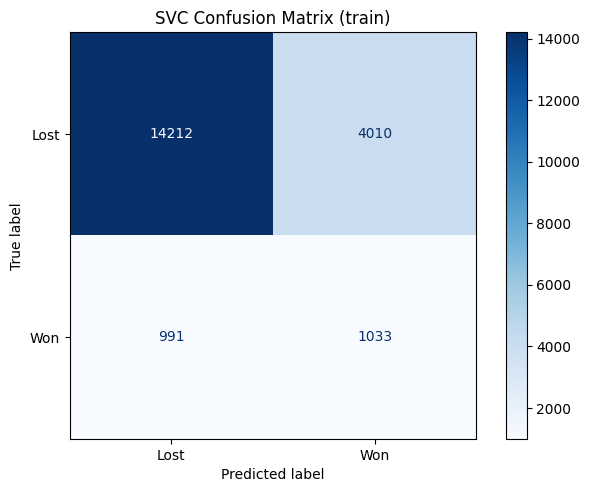

<Figure size 640x480 with 0 Axes>

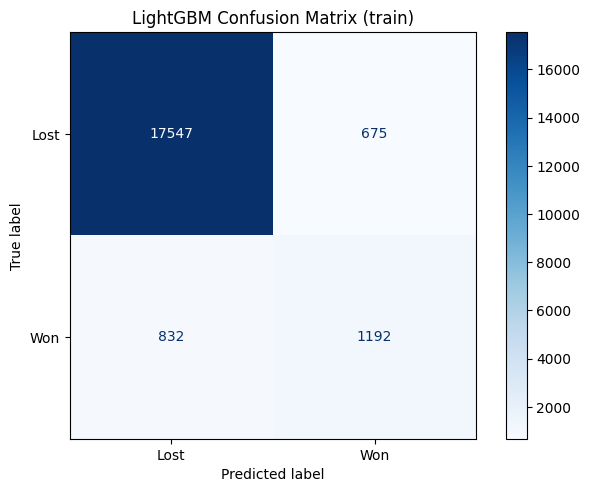

In [27]:
plot_confusion_matrix(train.target.astype(int), train.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix (train)")
plot_confusion_matrix(train.target.astype(int), train.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix (train)")